# 1. Preparation

## Load libraries

In [3]:
import numpy
import pandas
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, make_scorer, cohen_kappa_score, f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from math import ceil, sqrt
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
#TODO: try XGBoost... and StackNet for ensembling?
#import xgboost



## Load dataset

In [4]:
data = pandas.read_csv("../data/processed/train.csv")
notnull_data = data[data.notnull().all(axis=1)]
train = notnull_data.values
data2 = pandas.read_csv("../data/processed/test.csv")
notnull_data2 = data2[data2.notnull().all(axis=1)]
test = notnull_data2.values

# 2. Summarize data

In [5]:
print "Training dataset: ", train.shape
print "Testing dataset: ", test.shape
# We put the feature names for later reference
names = data.columns.values
print names[:10],"...",names[-10:]

Training dataset:  (4472, 7560)
Testing dataset:  (1044, 7560)
['Unnamed: 0' 'session' 'timestamp' 'value.Mean' 'value.SD' 'value.Fix'
 'value.Sac' 'value.Fix.Dur' 'value.Fix.Disp' 'value.Sac.Dur'] ... ['V993' 'V994' 'V995' 'V996' 'V997' 'V998' 'V999' 'V1000' 'Activity'
 'Social']


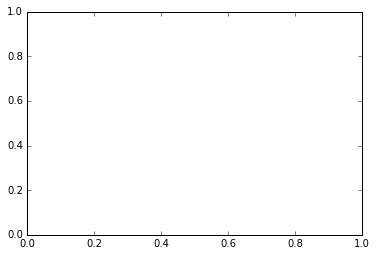

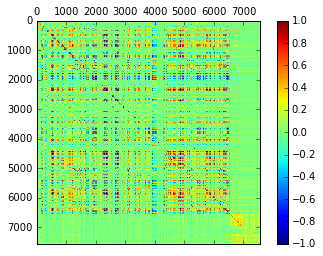

In [33]:
# Do a correlation plot?
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(data.corr(), vmin=-1, vmax=1, interpolation= 'none' )
fig.colorbar(cax)
plt.show()

# 3. Prepare data

## Data cleaning


In [6]:
# Separate the target values (Activity and Social) from features, etc.
X_train = train[:,3:7558].astype(float)
Y_trainA = train[:,7558] #Activity
Y_trainS = train[:,7559] #Social
X_test = test[:,3:7558].astype(float)
Y_testA = test[:,7558]
Y_testS = test[:,7559]
# feature_names of X
feature_names = names[3:7558]
idx_eyetracking = range(0,10)
idx_acc = range(10,150)
idx_audio = range(150,6555)
idx_video = range(6555,7555)
#print feature_names[idx_video]

# 4. Spot-check baseline algorithms, with different feature selection policies, SEPARATE DATA SOURCES

We create a pipeline for each feature selection policy (all features, PCA-selected, K-best-selected), in which we compare multiple simple ML algorithms

## Eyetracking

### All features

In [70]:
# Predicting Activity
X = X_train[:,idx_eyetracking]
Y = Y_trainA
Xval = X_test[:,idx_eyetracking]
Yval = Y_testA
print X.shape

# Test harness options and evaluation metric
num_folds = 10
num_instances = len(X)
seed = 7
scoring = 'f1_macro' # TODO: try others, like kappa? auc?
#scorer = make_scorer(roc_auc_score, average='macro')
#average = 'macro'
n_trees = 200 # Number of trees for boosting/RF
n_estimators = int(ceil(sqrt(X.shape[1]))) # Number of features for RF trees
print n_estimators

# Spot-Check Algorithms, including standardization
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),( 'LR' , LogisticRegression())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),( 'NB' , GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),( 'SVM' , SVC())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),( 'LDA' , LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledGBM' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'GBM' , GradientBoostingClassifier(n_estimators=n_trees, 
                                                                                random_state=seed))])))
pipelines.append(( 'ScaledRF' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'RF' , RandomForestClassifier(n_estimators=n_trees, 
                                                                         max_features=n_estimators,
                                                                         random_state=seed))])))

print 'Ready to train baseline eyetracking!'

(4472, 10)
4
Ready to train baseline eyetracking!


CV ScaledLR: 0.224209 (0.042085)
Test ScaledLR: 0.275338
CV ScaledNB: 0.151693 (0.051911)
Test ScaledNB: 0.184675
CV ScaledSVM: 0.235489 (0.061131)
Test ScaledSVM: 0.292449
CV ScaledLDA: 0.230847 (0.044008)
Test ScaledLDA: 0.275758
CV ScaledGBM: 0.284054 (0.044847)
Test ScaledGBM: 0.351540
CV ScaledRF: 0.284499 (0.039273)
Test ScaledRF: 0.335969


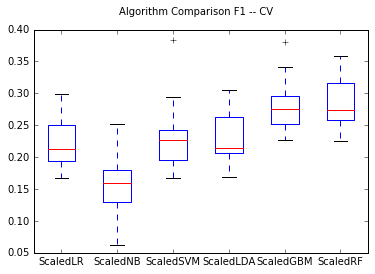

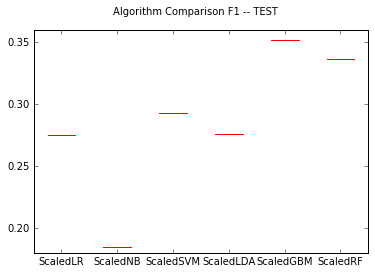

In [74]:
# evaluate each model in turn
cvresults = []
testresults = []
modelnames = []
for name, pipe in pipelines:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_result = cross_validation.cross_val_score(pipe, X, Y, cv=kfold, scoring=scoring)
    cvresults.append(cv_result)
    modelnames.append(name)
    msg = "CV %s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)
    pipe.fit(X,Y)
    predictions = pipe.predict(Xval)
    test_result = [f1_score(Yval, predictions, average='macro')]
    testresults.append(test_result)
    msg = "Test %s: %f" % (name, test_result[0])
    print(msg)
    
# Compare Algorithms graphically
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- CV' )
ax = fig.add_subplot(111)
plt.boxplot(cvresults)
ax.set_xticklabels(modelnames)
plt.show()
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- TEST' )
ax = fig.add_subplot(111)
plt.boxplot(testresults)
ax.set_xticklabels(modelnames)
plt.show()


### PCA, K-best (not done in this case, since there are only 10 features)

## Accelerometer

### All features

In [75]:
# Predicting Activity
X = X_train[:,idx_acc]
Y = Y_trainA
Xval = X_test[:,idx_acc]
Yval = Y_testA
print X.shape

# Test harness options and evaluation metric
num_folds = 10
num_instances = len(X)
seed = 7
scoring = 'f1_macro' # TODO: try others, like kappa? auc?
#scorer = make_scorer(roc_auc_score, average='macro')
#average = 'macro'
n_trees = 200 # Number of trees for boosting/RF
n_estimators = int(ceil(sqrt(X.shape[1]))) # Number of features for RF trees
print n_estimators

# Spot-Check Algorithms, including standardization
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),( 'LR' , LogisticRegression())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),( 'NB' , GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),( 'SVM' , SVC())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),( 'LDA' , LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledGBM' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'GBM' , GradientBoostingClassifier(n_estimators=n_trees, 
                                                                                random_state=seed))])))
pipelines.append(( 'ScaledRF' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'RF' , RandomForestClassifier(n_estimators=n_trees, 
                                                                         max_features=n_estimators,
                                                                         random_state=seed))])))

print 'Ready to train baseline accelerometer!'

(4472, 140)
12
Ready to train baseline accelerometer!


CV ScaledLR: 0.245908 (0.047876)
Test ScaledLR: 0.222218
CV ScaledNB: 0.175857 (0.046173)
Test ScaledNB: 0.201230
CV ScaledSVM: 0.239924 (0.059712)
Test ScaledSVM: 0.246870


/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


CV ScaledLDA: 0.242561 (0.055648)
Test ScaledLDA: 0.206830
CV ScaledGBM: 0.282829 (0.059464)
Test ScaledGBM: 0.209987
CV ScaledRF: 0.269031 (0.066201)
Test ScaledRF: 0.237184


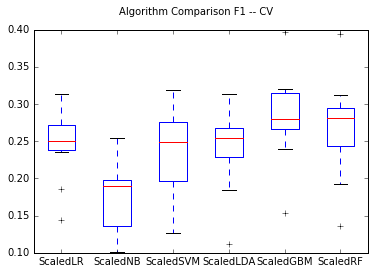

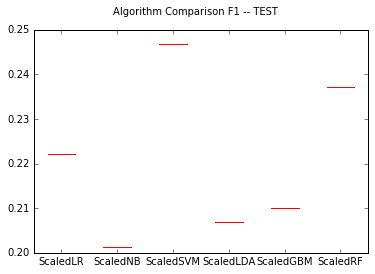

In [76]:
# evaluate each model in turn
cvresults = []
testresults = []
modelnames = []
for name, pipe in pipelines:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_result = cross_validation.cross_val_score(pipe, X, Y, cv=kfold, scoring=scoring)
    cvresults.append(cv_result)
    modelnames.append(name)
    msg = "CV %s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)
    pipe.fit(X,Y)
    predictions = pipe.predict(Xval)
    test_result = [f1_score(Yval, predictions, average='macro')]
    testresults.append(test_result)
    msg = "Test %s: %f" % (name, test_result[0])
    print(msg)
    
# Compare Algorithms graphically
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- CV' )
ax = fig.add_subplot(111)
plt.boxplot(cvresults)
ax.set_xticklabels(modelnames)
plt.show()
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- TEST' )
ax = fig.add_subplot(111)
plt.boxplot(testresults)
ax.set_xticklabels(modelnames)
plt.show()


SVM and RF/GBM seem to perform the best

### PCA

In [88]:
# Predicting Activity
X = X_train[:,idx_acc]
Y = Y_trainA
Xval = X_test[:,idx_acc]
Yval = Y_testA
print X.shape

# 5 components already explain almost all the variance
#pca = decomposition.PCA(n_components=5, whiten=True)
#Xpca = pca.fit_transform(X)
#Xvalpca = pca.transform(Xval)
#print 'Variance explained:'
#print pca.explained_variance_ratio_
#print 'Total variance explained by 20 components:'
#print sum(pca.explained_variance_ratio_)



# Test harness options and evaluation metric
n_components = 5
num_folds = 10
num_instances = len(X)
seed = 7
scoring = 'f1_macro' # TODO: try others, like kappa? auc?
#scorer = make_scorer(roc_auc_score, average='macro')
#average = 'macro'
n_trees = 200 # Number of trees for boosting/RF
n_estimators = int(ceil(sqrt(n_components))) # Number of features for RF trees
print n_estimators

# Spot-Check Algorithms, including standardization
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                          ( 'LR' , LogisticRegression())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                          ( 'NB' , GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                           ( 'SVM' , SVC())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                           ( 'LDA' , LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledGBM' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                           ( 'GBM' , GradientBoostingClassifier(n_estimators=n_trees, 
                                                                                random_state=seed))])))
pipelines.append(( 'ScaledRF' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                          ( 'RF' , RandomForestClassifier(n_estimators=n_trees, 
                                                                         max_features=n_estimators,
                                                                         random_state=seed))])))

print 'Ready to train baseline accelerometer PCA!'

(4472, 140)
3
Ready to train baseline accelerometer PCA!


Cross-validating ScaledLR
CV ScaledLR: 0.152574 (0.057446)
Test ScaledLR: 0.183298
Cross-validating ScaledNB
CV ScaledNB: 0.174068 (0.046658)
Test ScaledNB: 0.147683
Cross-validating ScaledSVM
CV ScaledSVM: 0.209870 (0.074800)
Test ScaledSVM: 0.189221
Cross-validating ScaledLDA
CV ScaledLDA: 0.160527 (0.052932)
Test ScaledLDA: 0.184524
Cross-validating ScaledGBM
CV ScaledGBM: 0.236999 (0.048140)
Test ScaledGBM: 0.191753
Cross-validating ScaledRF
CV ScaledRF: 0.240719 (0.043016)
Test ScaledRF: 0.186426


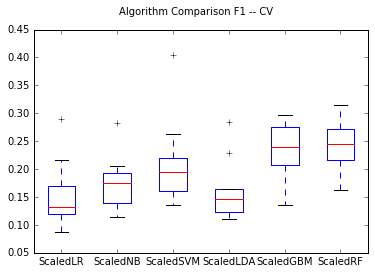

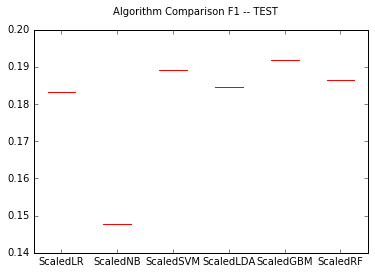

In [89]:
# evaluate each model in turn
cvresults = []
testresults = []
modelnames = []
for name, pipe in pipelines:
    print "Cross-validating %s" % name
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_result = cross_validation.cross_val_score(pipe, X, Y, cv=kfold, scoring=scoring)
    cvresults.append(cv_result)
    modelnames.append(name)
    msg = "CV %s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)
    pipe.fit(X,Y)
    predictions = pipe.predict(Xval)
    test_result = [f1_score(Yval, predictions, average='macro')]
    testresults.append(test_result)
    msg = "Test %s: %f" % (name, test_result[0])
    print(msg)
    
# Compare Algorithms graphically
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- CV' )
ax = fig.add_subplot(111)
plt.boxplot(cvresults)
ax.set_xticklabels(modelnames)
plt.show()
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- TEST' )
ax = fig.add_subplot(111)
plt.boxplot(testresults)
ax.set_xticklabels(modelnames)
plt.show()


Again, GBM/RF perform best (with SVM performing the best of the simple ones), but still worse than with the whole acc dataset

### K-best

In [94]:
# Predicting Activity
X = X_train[:,idx_acc]
Y = Y_trainA
Xval = X_test[:,idx_acc]
Yval = Y_testA
print X.shape

# We choose the number of features to select in a similar manner to the RF



# Test harness options and evaluation metric
n_features = int(ceil(sqrt(X.shape[1])))
num_folds = 10
num_instances = len(X)
seed = 7
scoring = 'f1_macro' # TODO: try others, like kappa? auc?
#scorer = make_scorer(roc_auc_score, average='macro')
#average = 'macro'
n_trees = 200 # Number of trees for boosting/RF
n_estimators = int(ceil(sqrt(n_features))) # Number of features for RF trees
print n_features, n_estimators

# Spot-Check Algorithms, including standardization
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                          ( 'LR' , LogisticRegression())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                          ( 'NB' , GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                           ( 'SVM' , SVC())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                           ( 'LDA' , LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledGBM' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                           ( 'GBM' , GradientBoostingClassifier(n_estimators=n_trees, 
                                                                                random_state=seed))])))
pipelines.append(( 'ScaledRF' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                          ( 'RF' , RandomForestClassifier(n_estimators=n_trees, 
                                                                         max_features=n_estimators,
                                                                         random_state=seed))])))

print 'Ready to train baseline accelerometer Kbest!'

(4472, 140)
12 4
Ready to train baseline accelerometer Kbest!


Cross-validating ScaledLR
CV ScaledLR: 0.188381 (0.056158)
Test ScaledLR: 0.188798
Cross-validating ScaledNB
CV ScaledNB: 0.185748 (0.045934)
Test ScaledNB: 0.111768
Cross-validating ScaledSVM
CV ScaledSVM: 0.205694 (0.052618)
Test ScaledSVM: 0.154502
Cross-validating ScaledLDA
CV ScaledLDA: 0.197614 (0.056388)
Test ScaledLDA: 0.192650
Cross-validating ScaledGBM
CV ScaledGBM: 0.243517 (0.055513)
Test ScaledGBM: 0.164120
Cross-validating ScaledRF
CV ScaledRF: 0.243158 (0.052087)
Test ScaledRF: 0.182148


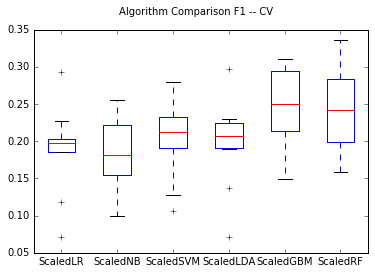

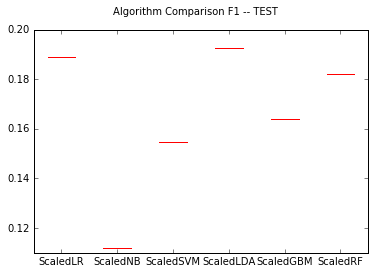

In [95]:
# evaluate each model in turn
cvresults = []
testresults = []
modelnames = []
for name, pipe in pipelines:
    print "Cross-validating %s" % name
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_result = cross_validation.cross_val_score(pipe, X, Y, cv=kfold, scoring=scoring)
    cvresults.append(cv_result)
    modelnames.append(name)
    msg = "CV %s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)
    pipe.fit(X,Y)
    predictions = pipe.predict(Xval)
    test_result = [f1_score(Yval, predictions, average='macro')]
    testresults.append(test_result)
    msg = "Test %s: %f" % (name, test_result[0])
    print(msg)
    
# Compare Algorithms graphically
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- CV' )
ax = fig.add_subplot(111)
plt.boxplot(cvresults)
ax.set_xticklabels(modelnames)
plt.show()
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- TEST' )
ax = fig.add_subplot(111)
plt.boxplot(testresults)
ax.set_xticklabels(modelnames)
plt.show()

Here the performance is debatable, with GBM/RF having best performance, but still worse than with the whole acc dataset

## Audio

### All





In [7]:
# Predicting Activity
X = X_train[:,idx_audio]
Y = Y_trainA
Xval = X_test[:,idx_audio]
Yval = Y_testA
print X.shape

# Test harness options and evaluation metric
num_folds = 10
num_instances = len(X)
seed = 7
scoring = 'f1_macro' # TODO: try others, like kappa? auc?
#scorer = make_scorer(roc_auc_score, average='macro')
#average = 'macro'
n_trees = 200 # Number of trees for boosting/RF
n_estimators = int(ceil(sqrt(X.shape[1]))) # Number of features for RF trees
print n_estimators

# Spot-Check Algorithms, including standardization
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),( 'LR' , LogisticRegression())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),( 'NB' , GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),( 'SVM' , SVC())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),( 'LDA' , LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledGBM' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'GBM' , GradientBoostingClassifier(n_estimators=n_trees, 
                                                                                random_state=seed))])))
pipelines.append(( 'ScaledRF' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'RF' , RandomForestClassifier(n_estimators=n_trees, 
                                                                         max_features=n_estimators,
                                                                         random_state=seed))])))

print 'Ready to train baseline audio!'

(4472, 6405)
81
Ready to train baseline audio!


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


CV ScaledLR: 0.375897 (0.043594)
Test ScaledLR: 0.432263


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CV ScaledNB: 0.284832 (0.056520)
Test ScaledNB: 0.355220
CV ScaledSVM: 0.416700 (0.045207)
Test ScaledSVM: 0.512060


/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


CV ScaledLDA: 0.273938 (0.031295)
Test ScaledLDA: 0.287309
CV ScaledGBM: 0.435210 (0.044357)
Test ScaledGBM: 0.497674
CV ScaledRF: 0.408938 (0.050887)
Test ScaledRF: 0.472225


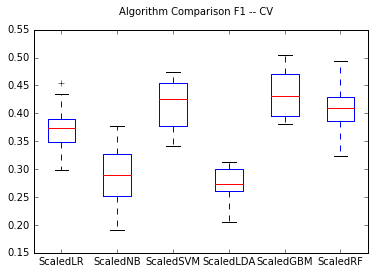

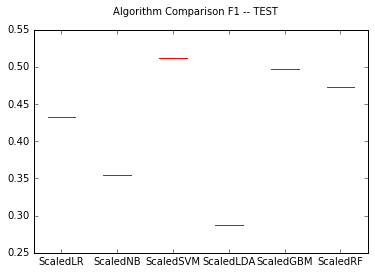

In [8]:
#TODO: This takes too much time to train and CV!!!
# evaluate each model in turn
cvresults = []
testresults = []
modelnames = []
for name, pipe in pipelines:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_result = cross_validation.cross_val_score(pipe, X, Y, cv=kfold, scoring=scoring)
    cvresults.append(cv_result)
    modelnames.append(name)
    msg = "CV %s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)
    pipe.fit(X,Y)
    predictions = pipe.predict(Xval)
    test_result = [f1_score(Yval, predictions, average='macro')]
    testresults.append(test_result)
    msg = "Test %s: %f" % (name, test_result[0])
    print(msg)
    
# Compare Algorithms graphically
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- CV' )
ax = fig.add_subplot(111)
plt.boxplot(cvresults)
ax.set_xticklabels(modelnames)
plt.show()
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- TEST' )
ax = fig.add_subplot(111)
plt.boxplot(testresults)
ax.set_xticklabels(modelnames)
plt.show()

### PCA


In [101]:
# Predicting Activity
X = X_train[:,idx_audio]
Y = Y_trainA
Xval = X_test[:,idx_audio]
Yval = Y_testA
print X.shape

# 4 components already explain almost all the variance
pca = decomposition.PCA(n_components=4, whiten=True)
Xpca = pca.fit_transform(X)
Xvalpca = pca.transform(Xval)
print 'Variance explained:'
print pca.explained_variance_ratio_
print 'Total variance explained by 100 components:'
print sum(pca.explained_variance_ratio_)

(4472, 6405)
Variance explained:
[  9.98672773e-01   7.66760752e-04   5.60055813e-04   4.08182306e-07]
Total variance explained by 100 components:
0.999999997857


In [102]:
# Test harness options and evaluation metric
n_components = 4
num_folds = 10
num_instances = len(X)
seed = 7
scoring = 'f1_macro' # TODO: try others, like kappa? auc?
#scorer = make_scorer(roc_auc_score, average='macro')
#average = 'macro'
n_trees = 200 # Number of trees for boosting/RF
n_estimators = int(ceil(sqrt(n_components))) # Number of features for RF trees
print n_estimators

# Spot-Check Algorithms, including standardization
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                          ( 'LR' , LogisticRegression())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                          ( 'NB' , GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                           ( 'SVM' , SVC())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                           ( 'LDA' , LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledGBM' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                           ( 'GBM' , GradientBoostingClassifier(n_estimators=n_trees, 
                                                                                random_state=seed))])))
pipelines.append(( 'ScaledRF' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                          ( 'RF' , RandomForestClassifier(n_estimators=n_trees, 
                                                                         max_features=n_estimators,
                                                                         random_state=seed))])))

print 'Ready to train baseline audio PCA!'

2
Ready to train baseline audio PCA!


Cross-validating ScaledLR
CV ScaledLR: 0.279211 (0.048940)
Test ScaledLR: 0.320745
Cross-validating ScaledNB
CV ScaledNB: 0.282217 (0.067549)
Test ScaledNB: 0.355709
Cross-validating ScaledSVM
CV ScaledSVM: 0.351194 (0.043061)
Test ScaledSVM: 0.431086
Cross-validating ScaledLDA
CV ScaledLDA: 0.267877 (0.067013)
Test ScaledLDA: 0.338926
Cross-validating ScaledGBM
CV ScaledGBM: 0.359703 (0.055307)
Test ScaledGBM: 0.424793
Cross-validating ScaledRF
CV ScaledRF: 0.360143 (0.055772)
Test ScaledRF: 0.418797


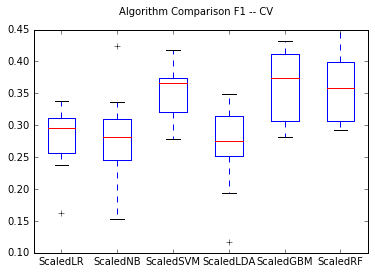

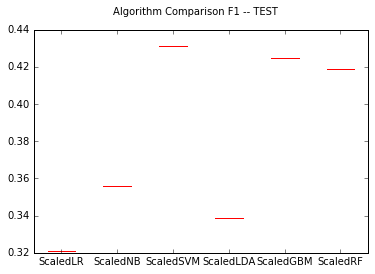

In [103]:
# evaluate each model in turn
cvresults = []
testresults = []
modelnames = []
for name, pipe in pipelines:
    print "Cross-validating %s" % name
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_result = cross_validation.cross_val_score(pipe, X, Y, cv=kfold, scoring=scoring)
    cvresults.append(cv_result)
    modelnames.append(name)
    msg = "CV %s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)
    pipe.fit(X,Y)
    predictions = pipe.predict(Xval)
    test_result = [f1_score(Yval, predictions, average='macro')]
    testresults.append(test_result)
    msg = "Test %s: %f" % (name, test_result[0])
    print(msg)
    
# Compare Algorithms graphically
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- CV' )
ax = fig.add_subplot(111)
plt.boxplot(cvresults)
ax.set_xticklabels(modelnames)
plt.show()
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- TEST' )
ax = fig.add_subplot(111)
plt.boxplot(testresults)
ax.set_xticklabels(modelnames)
plt.show()

Better performance than the other data sources... SVM, and GBM/RF still perform the best

### KBest

In [105]:
# Predicting Activity
X = X_train[:,idx_audio]
Y = Y_trainA
Xval = X_test[:,idx_audio]
Yval = Y_testA
print X.shape

# We choose the number of features to select in a similar manner to the RF

# Test harness options and evaluation metric
n_features = int(ceil(sqrt(X.shape[1])))
num_folds = 10
num_instances = len(X)
seed = 7
scoring = 'f1_macro' # TODO: try others, like kappa? auc?
#scorer = make_scorer(roc_auc_score, average='macro')
#average = 'macro'
n_trees = 200 # Number of trees for boosting/RF
n_estimators = int(ceil(sqrt(n_features))) # Number of features for RF trees
print n_features, n_estimators

# Spot-Check Algorithms, including standardization
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                          ( 'LR' , LogisticRegression())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                          ( 'NB' , GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                           ( 'SVM' , SVC())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                           ( 'LDA' , LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledGBM' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                           ( 'GBM' , GradientBoostingClassifier(n_estimators=n_trees, 
                                                                                random_state=seed))])))
pipelines.append(( 'ScaledRF' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                          ( 'RF' , RandomForestClassifier(n_estimators=n_trees, 
                                                                         max_features=n_estimators,
                                                                         random_state=seed))])))

print 'Ready to train baseline audio Kbest!'

(4472, 6405)
81 9
Ready to train baseline audio Kbest!


Cross-validating ScaledLR


/usr/local/lib/python2.7/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [13] are constant.
  UserWarning)


CV ScaledLR: 0.330666 (0.062125)
Test ScaledLR: 0.395710
Cross-validating ScaledNB
CV ScaledNB: 0.299657 (0.052693)
Test ScaledNB: 0.330956
Cross-validating ScaledSVM
CV ScaledSVM: 0.312356 (0.036404)
Test ScaledSVM: 0.355394
Cross-validating ScaledLDA
CV ScaledLDA: 0.355959 (0.055863)
Test ScaledLDA: 0.402554
Cross-validating ScaledGBM
CV ScaledGBM: 0.348206 (0.047033)
Test ScaledGBM: 0.377424
Cross-validating ScaledRF
CV ScaledRF: 0.343128 (0.044539)
Test ScaledRF: 0.382774


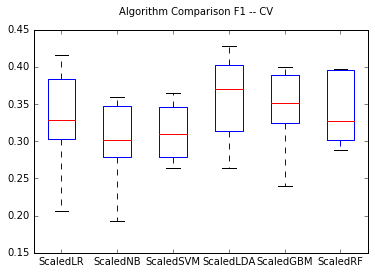

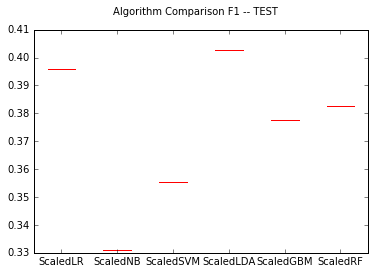

In [106]:
# evaluate each model in turn
cvresults = []
testresults = []
modelnames = []
for name, pipe in pipelines:
    print "Cross-validating %s" % name
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_result = cross_validation.cross_val_score(pipe, X, Y, cv=kfold, scoring=scoring)
    cvresults.append(cv_result)
    modelnames.append(name)
    msg = "CV %s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)
    pipe.fit(X,Y)
    predictions = pipe.predict(Xval)
    test_result = [f1_score(Yval, predictions, average='macro')]
    testresults.append(test_result)
    msg = "Test %s: %f" % (name, test_result[0])
    print(msg)
    
# Compare Algorithms graphically
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- CV' )
ax = fig.add_subplot(111)
plt.boxplot(cvresults)
ax.set_xticklabels(modelnames)
plt.show()
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- TEST' )
ax = fig.add_subplot(111)
plt.boxplot(testresults)
ax.set_xticklabels(modelnames)
plt.show()

Interestingly, in this case LR and LDA give better results in the test set... but still lower than using PCA

## Video


### All



In [107]:
# Predicting Activity
X = X_train[:,idx_video]
Y = Y_trainA
Xval = X_test[:,idx_video]
Yval = Y_testA
print X.shape

# Test harness options and evaluation metric
num_folds = 10
num_instances = len(X)
seed = 7
scoring = 'f1_macro' # TODO: try others, like kappa? auc?
#scorer = make_scorer(roc_auc_score, average='macro')
#average = 'macro'
n_trees = 200 # Number of trees for boosting/RF
n_estimators = int(ceil(sqrt(X.shape[1]))) # Number of features for RF trees
print n_estimators

# Spot-Check Algorithms, including standardization
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),( 'LR' , LogisticRegression())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),( 'NB' , GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),( 'SVM' , SVC())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),( 'LDA' , LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledGBM' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'GBM' , GradientBoostingClassifier(n_estimators=n_trees, 
                                                                                random_state=seed))])))
pipelines.append(( 'ScaledRF' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'RF' , RandomForestClassifier(n_estimators=n_trees, 
                                                                         max_features=n_estimators,
                                                                         random_state=seed))])))

print 'Ready to train baseline video!'

(4472, 1000)
32
Ready to train baseline video!


CV ScaledLR: 0.202456 (0.012180)
Test ScaledLR: 0.238935
CV ScaledNB: 0.202616 (0.023832)
Test ScaledNB: 0.208848
CV ScaledSVM: 0.176287 (0.040691)
Test ScaledSVM: 0.194921
CV ScaledLDA: 0.204198 (0.015141)
Test ScaledLDA: 0.228039
CV ScaledGBM: 0.202711 (0.030129)
Test ScaledGBM: 0.215131
CV ScaledRF: 0.168582 (0.045488)
Test ScaledRF: 0.171398


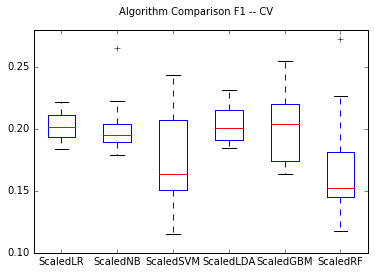

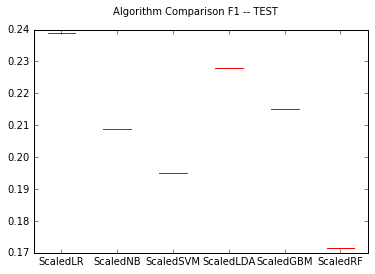

In [108]:
# evaluate each model in turn
cvresults = []
testresults = []
modelnames = []
for name, pipe in pipelines:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_result = cross_validation.cross_val_score(pipe, X, Y, cv=kfold, scoring=scoring)
    cvresults.append(cv_result)
    modelnames.append(name)
    msg = "CV %s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)
    pipe.fit(X,Y)
    predictions = pipe.predict(Xval)
    test_result = [f1_score(Yval, predictions, average='macro')]
    testresults.append(test_result)
    msg = "Test %s: %f" % (name, test_result[0])
    print(msg)
    
# Compare Algorithms graphically
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- CV' )
ax = fig.add_subplot(111)
plt.boxplot(cvresults)
ax.set_xticklabels(modelnames)
plt.show()
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- TEST' )
ax = fig.add_subplot(111)
plt.boxplot(testresults)
ax.set_xticklabels(modelnames)
plt.show()

LR and LDA perform the best, but performance is not very good compared to other data sources

### PCA

In [111]:
# Predicting Activity
X = X_train[:,idx_video]
Y = Y_trainA
Xval = X_test[:,idx_video]
Yval = Y_testA
print X.shape

# 10 components already explain almost all the variance
pca = decomposition.PCA(n_components=10, whiten=True)
Xpca = pca.fit_transform(X)
Xvalpca = pca.transform(Xval)
print 'Variance explained:'
print pca.explained_variance_ratio_
print 'Total variance explained by 10 components:'
print sum(pca.explained_variance_ratio_)

(4472, 1000)
Variance explained:
[ 0.78311927  0.0599323   0.02861801  0.02031511  0.01679224  0.0151559
  0.00821279  0.00671572  0.00466753  0.00384518]
Total variance explained by 10 components:
0.947374066012


In [112]:
# Test harness options and evaluation metric
n_components = 10
num_folds = 10
num_instances = len(X)
seed = 7
scoring = 'f1_macro' # TODO: try others, like kappa? auc?
#scorer = make_scorer(roc_auc_score, average='macro')
#average = 'macro'
n_trees = 200 # Number of trees for boosting/RF
n_estimators = int(ceil(sqrt(n_components))) # Number of features for RF trees
print n_estimators

# Spot-Check Algorithms, including standardization
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                          ( 'LR' , LogisticRegression())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                          ( 'NB' , GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                           ( 'SVM' , SVC())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                           ( 'LDA' , LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledGBM' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                           ( 'GBM' , GradientBoostingClassifier(n_estimators=n_trees, 
                                                                                random_state=seed))])))
pipelines.append(( 'ScaledRF' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                          ( 'RF' , RandomForestClassifier(n_estimators=n_trees, 
                                                                         max_features=n_estimators,
                                                                         random_state=seed))])))

print 'Ready to train baseline video PCA!'

4
Ready to train baseline video PCA!


Cross-validating ScaledLR
CV ScaledLR: 0.179147 (0.044872)
Test ScaledLR: 0.195787
Cross-validating ScaledNB
CV ScaledNB: 0.188396 (0.022775)
Test ScaledNB: 0.203217
Cross-validating ScaledSVM
CV ScaledSVM: 0.175041 (0.039829)
Test ScaledSVM: 0.172379
Cross-validating ScaledLDA
CV ScaledLDA: 0.185605 (0.046647)
Test ScaledLDA: 0.200930
Cross-validating ScaledGBM
CV ScaledGBM: 0.198027 (0.032886)
Test ScaledGBM: 0.242988
Cross-validating ScaledRF
CV ScaledRF: 0.192456 (0.029042)
Test ScaledRF: 0.206081


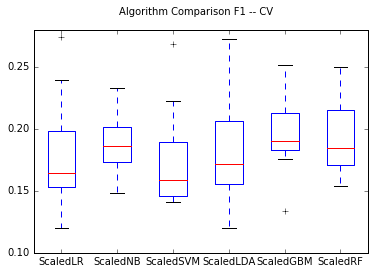

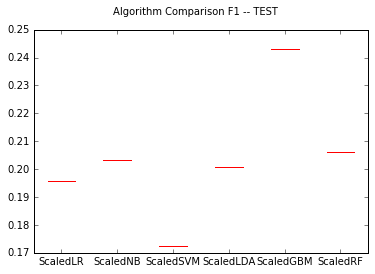

In [113]:
# evaluate each model in turn
cvresults = []
testresults = []
modelnames = []
for name, pipe in pipelines:
    print "Cross-validating %s" % name
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_result = cross_validation.cross_val_score(pipe, X, Y, cv=kfold, scoring=scoring)
    cvresults.append(cv_result)
    modelnames.append(name)
    msg = "CV %s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)
    pipe.fit(X,Y)
    predictions = pipe.predict(Xval)
    test_result = [f1_score(Yval, predictions, average='macro')]
    testresults.append(test_result)
    msg = "Test %s: %f" % (name, test_result[0])
    print(msg)
    
# Compare Algorithms graphically
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- CV' )
ax = fig.add_subplot(111)
plt.boxplot(cvresults)
ax.set_xticklabels(modelnames)
plt.show()
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- TEST' )
ax = fig.add_subplot(111)
plt.boxplot(testresults)
ax.set_xticklabels(modelnames)
plt.show()

The PCA version performs the same (or slightly better) than the raw video features, with GBM being the most successful on the test set


### KBest

In [114]:
# Predicting Activity
X = X_train[:,idx_video]
Y = Y_trainA
Xval = X_test[:,idx_video]
Yval = Y_testA
print X.shape

# We choose the number of features to select in a similar manner to the RF

# Test harness options and evaluation metric
n_features = int(ceil(sqrt(X.shape[1])))
num_folds = 10
num_instances = len(X)
seed = 7
scoring = 'f1_macro' # TODO: try others, like kappa? auc?
#scorer = make_scorer(roc_auc_score, average='macro')
#average = 'macro'
n_trees = 200 # Number of trees for boosting/RF
n_estimators = int(ceil(sqrt(n_features))) # Number of features for RF trees
print n_features, n_estimators

# Spot-Check Algorithms, including standardization
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                          ( 'LR' , LogisticRegression())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                          ( 'NB' , GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                           ( 'SVM' , SVC())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                           ( 'LDA' , LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledGBM' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                           ( 'GBM' , GradientBoostingClassifier(n_estimators=n_trees, 
                                                                                random_state=seed))])))
pipelines.append(( 'ScaledRF' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                          ( 'RF' , RandomForestClassifier(n_estimators=n_trees, 
                                                                         max_features=n_estimators,
                                                                         random_state=seed))])))

print 'Ready to train baseline video Kbest!'

(4472, 1000)
32 6
Ready to train baseline video Kbest!


Cross-validating ScaledLR
CV ScaledLR: 0.171584 (0.033453)
Test ScaledLR: 0.213346
Cross-validating ScaledNB
CV ScaledNB: 0.197547 (0.018918)
Test ScaledNB: 0.225345
Cross-validating ScaledSVM
CV ScaledSVM: 0.163461 (0.034569)
Test ScaledSVM: 0.188380
Cross-validating ScaledLDA
CV ScaledLDA: 0.175643 (0.028999)
Test ScaledLDA: 0.225039
Cross-validating ScaledGBM
CV ScaledGBM: 0.192576 (0.028927)
Test ScaledGBM: 0.248863
Cross-validating ScaledRF
CV ScaledRF: 0.180619 (0.042169)
Test ScaledRF: 0.196353


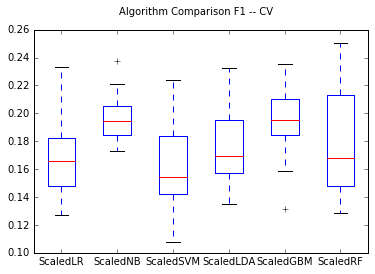

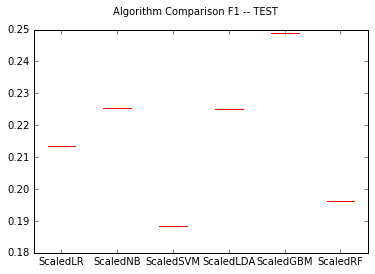

In [115]:
# evaluate each model in turn
cvresults = []
testresults = []
modelnames = []
for name, pipe in pipelines:
    print "Cross-validating %s" % name
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_result = cross_validation.cross_val_score(pipe, X, Y, cv=kfold, scoring=scoring)
    cvresults.append(cv_result)
    modelnames.append(name)
    msg = "CV %s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)
    pipe.fit(X,Y)
    predictions = pipe.predict(Xval)
    test_result = [f1_score(Yval, predictions, average='macro')]
    testresults.append(test_result)
    msg = "Test %s: %f" % (name, test_result[0])
    print(msg)
    
# Compare Algorithms graphically
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- CV' )
ax = fig.add_subplot(111)
plt.boxplot(cvresults)
ax.set_xticklabels(modelnames)
plt.show()
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- TEST' )
ax = fig.add_subplot(111)
plt.boxplot(testresults)
ax.set_xticklabels(modelnames)
plt.show()

The k-best method has similar performance to the PCA one, with GBM performing the best

# 5. Spot-check baseline algorithms, with different feature selection policies, MULTIMODAL DATA

We create a pipeline for each feature selection policy (all features, PCA-selected, K-best-selected), in which we compare multiple simple ML algorithms

## Feature-level fusion

### All

In [11]:
# Predicting Activity
X = X_train
Y = Y_trainA
Xval = X_test
Yval = Y_testA
print X.shape

# Test harness options and evaluation metric
num_folds = 10
num_instances = len(X)
seed = 7
scoring = 'f1_macro' # TODO: try others, like kappa? auc?
#scorer = make_scorer(roc_auc_score, average='macro')
#average = 'macro'
n_trees = 200 # Number of trees for boosting/RF
n_estimators = int(ceil(sqrt(X.shape[1]))) # Number of features for RF trees
print n_estimators

# Spot-Check Algorithms, including standardization
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),( 'LR' , LogisticRegression())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),( 'NB' , GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),( 'SVM' , SVC())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),( 'LDA' , LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledGBM' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'GBM' , GradientBoostingClassifier(n_estimators=n_trees, 
                                                                                random_state=seed))])))
pipelines.append(( 'ScaledRF' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'RF' , RandomForestClassifier(n_estimators=n_trees, 
                                                                         max_features=n_estimators,
                                                                         random_state=seed))])))

print 'Ready to train baseline multimodal feature-fusion!'

(4472, 7555)
87
Ready to train baseline multimodal feature-fusion!


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


CV ScaledLR: 0.394729 (0.047808)
Test ScaledLR: 0.430602
CV ScaledNB: 0.286299 (0.056914)
Test ScaledNB: 0.347041
CV ScaledSVM: 0.428303 (0.054377)
Test ScaledSVM: 0.505376


/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


CV ScaledLDA: 0.317988 (0.029782)
Test ScaledLDA: 0.387093
CV ScaledGBM: 0.449031 (0.048987)
Test ScaledGBM: 0.488341
CV ScaledRF: 0.422377 (0.047958)
Test ScaledRF: 0.467806


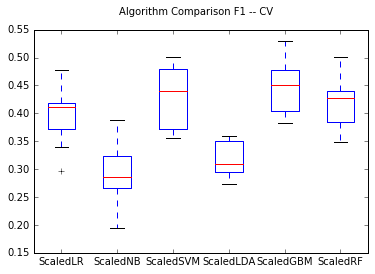

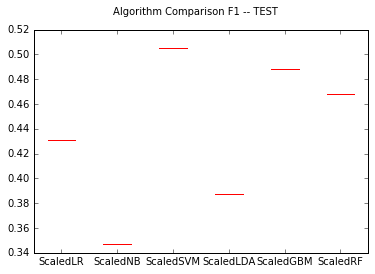

In [12]:
# evaluate each model in turn
cvresults = []
testresults = []
modelnames = []
for name, pipe in pipelines:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_result = cross_validation.cross_val_score(pipe, X, Y, cv=kfold, scoring=scoring)
    cvresults.append(cv_result)
    modelnames.append(name)
    msg = "CV %s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)
    pipe.fit(X,Y)
    predictions = pipe.predict(Xval)
    test_result = [f1_score(Yval, predictions, average='macro')]
    testresults.append(test_result)
    msg = "Test %s: %f" % (name, test_result[0])
    print(msg)
    
# Compare Algorithms graphically
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- CV' )
ax = fig.add_subplot(111)
plt.boxplot(cvresults)
ax.set_xticklabels(modelnames)
plt.show()
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- TEST' )
ax = fig.add_subplot(111)
plt.boxplot(testresults)
ax.set_xticklabels(modelnames)
plt.show()

GBM again is one of the best performers, but surprisingly, SVM performs even better in the test set (F1=0.5)

In [7]:

model = xgboost.XGBClassifier()


name='XGBoost'
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
cv_result = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
msg = "XGBoost - CV %s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
print(msg)
model.fit(X,Y)
predictions = model.predict(Xval)
test_result = [f1_score(Yval, predictions, average='macro')]
msg = "XGBoost - Test %s: %f" % (name, test_result[0])
print(msg)


XGBoost - CV XGBoost: 0.441052 (0.054434)
XGBoost - Test XGBoost: 0.466361


We see that in this case, XGBoost performs on par (or slightly better than) the best baseline models we have tried

In [10]:
print "Accuracy XGBoost",accuracy_score(Yval, predictions)
print "Kappa XGBoost",cohen_kappa_score(Yval, predictions)
print confusion_matrix(Yval, predictions)

 Accuracy XGBoost 0.543103448276
Kappa XGBoost 0.383679743367
[[174   2  20   4   0]
 [  7 152 129   9  28]
 [ 63  54 200   6  14]
 [ 40   4  31  13   7]
 [  6  32  20   1  28]]


... but still slightly worse than the RF baseline model we did in R

### PCA


In [120]:
# Predicting Activity
X = X_train
Y = Y_trainA
Xval = X_test
Yval = Y_testA
print X.shape

# 100 components already explain almost all the variance (THAT's STRANGE! RECHECK!) 
# Does introducing the standardscaler before PCA change the amount of variance explained???? 
# TODO: set all PCA pipelines to 'mle' for an heuristic to get the n_components!
pca = decomposition.PCA(n_components=10, whiten=True)
Xpca = pca.fit_transform(X)
Xvalpca = pca.transform(Xval)
print 'Variance explained:'
print pca.explained_variance_ratio_
print 'Total variance explained by 10 components:'
print sum(pca.explained_variance_ratio_)

(4472, 7555)
Variance explained:
[  9.98672773e-01   7.66760752e-04   5.60055813e-04   4.08182307e-07
   1.67856780e-09   4.37711545e-10   1.28340598e-11   4.44481899e-12
   2.73657276e-12   2.47765886e-12]
Total variance explained by 100 components:
0.999999999994


In [121]:
# Test harness options and evaluation metric
n_components = 10
num_folds = 10
num_instances = len(X)
seed = 7
scoring = 'f1_macro' # TODO: try others, like kappa? auc?
#scorer = make_scorer(roc_auc_score, average='macro')
#average = 'macro'
n_trees = 200 # Number of trees for boosting/RF
n_estimators = int(ceil(sqrt(n_components))) # Number of features for RF trees
print n_estimators

# Spot-Check Algorithms, including standardization
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                          ( 'LR' , LogisticRegression())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                          ( 'NB' , GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                           ( 'SVM' , SVC())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                           ( 'LDA' , LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledGBM' , Pipeline([( 'Scaler' , StandardScaler()),
                                           ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                           ( 'GBM' , GradientBoostingClassifier(n_estimators=n_trees, 
                                                                                random_state=seed))])))
pipelines.append(( 'ScaledRF' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'pca' , PCA(n_components=n_components, whiten=True)),
                                          ( 'RF' , RandomForestClassifier(n_estimators=n_trees, 
                                                                         max_features=n_estimators,
                                                                         random_state=seed))])))

print 'Ready to train baseline allfeatures PCA!'

4
Ready to train baseline allfeatures PCA!


Cross-validating ScaledLR
CV ScaledLR: 0.286518 (0.059289)
Test ScaledLR: 0.363873
Cross-validating ScaledNB
CV ScaledNB: 0.297802 (0.074520)
Test ScaledNB: 0.403917
Cross-validating ScaledSVM
CV ScaledSVM: 0.369010 (0.049730)
Test ScaledSVM: 0.449251
Cross-validating ScaledLDA
CV ScaledLDA: 0.278094 (0.080699)
Test ScaledLDA: 0.360579
Cross-validating ScaledGBM
CV ScaledGBM: 0.372510 (0.066044)
Test ScaledGBM: 0.455387
Cross-validating ScaledRF
CV ScaledRF: 0.386380 (0.051127)
Test ScaledRF: 0.441504


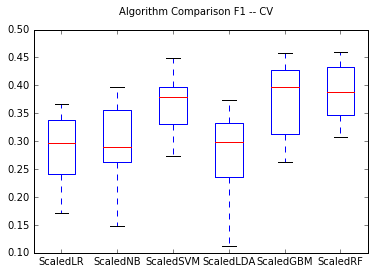

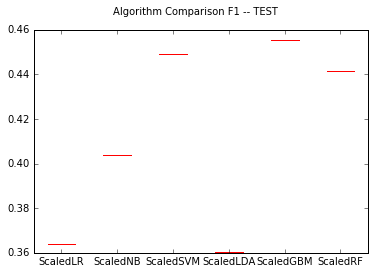

In [122]:
# evaluate each model in turn
cvresults = []
testresults = []
modelnames = []
for name, pipe in pipelines:
    print "Cross-validating %s" % name
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_result = cross_validation.cross_val_score(pipe, X, Y, cv=kfold, scoring=scoring)
    cvresults.append(cv_result)
    modelnames.append(name)
    msg = "CV %s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)
    pipe.fit(X,Y)
    predictions = pipe.predict(Xval)
    test_result = [f1_score(Yval, predictions, average='macro')]
    testresults.append(test_result)
    msg = "Test %s: %f" % (name, test_result[0])
    print(msg)
    
# Compare Algorithms graphically
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- CV' )
ax = fig.add_subplot(111)
plt.boxplot(cvresults)
ax.set_xticklabels(modelnames)
plt.show()
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- TEST' )
ax = fig.add_subplot(111)
plt.boxplot(testresults)
ax.set_xticklabels(modelnames)
plt.show()

SVM and GBM seem to perform best, with F1 around 0.4-0.45

### K-Best

In [123]:
# Predicting Activity
X = X_train
Y = Y_trainA
Xval = X_test
Yval = Y_testA
print X.shape

# We choose the number of features to select in a similar manner to the RF

# Test harness options and evaluation metric
n_features = int(ceil(sqrt(X.shape[1])))
num_folds = 10
num_instances = len(X)
seed = 7
scoring = 'f1_macro' # TODO: try others, like kappa? auc?
#scorer = make_scorer(roc_auc_score, average='macro')
#average = 'macro'
n_trees = 200 # Number of trees for boosting/RF
n_estimators = int(ceil(sqrt(n_features))) # Number of features for RF trees
print n_features, n_estimators

# Spot-Check Algorithms, including standardization
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                          ( 'LR' , LogisticRegression())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                          ( 'NB' , GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                           ( 'SVM' , SVC())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                           ( 'LDA' , LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledGBM' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                           ( 'GBM' , GradientBoostingClassifier(n_estimators=n_trees, 
                                                                                random_state=seed))])))
pipelines.append(( 'ScaledRF' , Pipeline([( 'Scaler' , StandardScaler()),
                                          ( 'kbest' , SelectKBest(score_func=f_classif, k=n_features)),
                                          ( 'RF' , RandomForestClassifier(n_estimators=n_trees, 
                                                                         max_features=n_estimators,
                                                                         random_state=seed))])))

print 'Ready to train baseline allfeatures Kbest!'

(4472, 7555)
87 10
Ready to train baseline allfeatures Kbest!


Cross-validating ScaledLR


/usr/local/lib/python2.7/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [163] are constant.
  UserWarning)


CV ScaledLR: 0.340662 (0.061034)
Test ScaledLR: 0.388526
Cross-validating ScaledNB
CV ScaledNB: 0.298561 (0.052735)
Test ScaledNB: 0.329277
Cross-validating ScaledSVM
CV ScaledSVM: 0.319557 (0.037683)
Test ScaledSVM: 0.360569
Cross-validating ScaledLDA
CV ScaledLDA: 0.365653 (0.056421)
Test ScaledLDA: 0.391882
Cross-validating ScaledGBM
CV ScaledGBM: 0.362559 (0.036327)
Test ScaledGBM: 0.384674
Cross-validating ScaledRF
CV ScaledRF: 0.348947 (0.040781)
Test ScaledRF: 0.388761


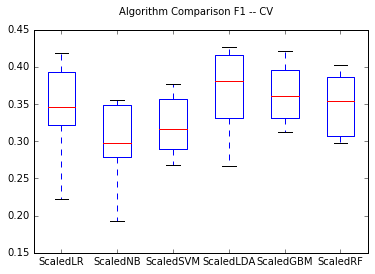

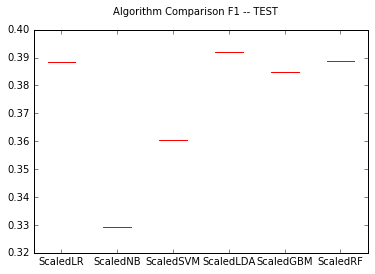

In [124]:
# evaluate each model in turn
cvresults = []
testresults = []
modelnames = []
for name, pipe in pipelines:
    print "Cross-validating %s" % name
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_result = cross_validation.cross_val_score(pipe, X, Y, cv=kfold, scoring=scoring)
    cvresults.append(cv_result)
    modelnames.append(name)
    msg = "CV %s: %f (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)
    pipe.fit(X,Y)
    predictions = pipe.predict(Xval)
    test_result = [f1_score(Yval, predictions, average='macro')]
    testresults.append(test_result)
    msg = "Test %s: %f" % (name, test_result[0])
    print(msg)
    
# Compare Algorithms graphically
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- CV' )
ax = fig.add_subplot(111)
plt.boxplot(cvresults)
ax.set_xticklabels(modelnames)
plt.show()
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison F1 -- TEST' )
ax = fig.add_subplot(111)
plt.boxplot(testresults)
ax.set_xticklabels(modelnames)
plt.show()

Oddly, LDA, LR, GBM and RF perform best in this case, in the vicinity of F1=0.4 (slightly worse than PCA features)

## Decision-level fusion

### Voting

### Weighted voting with random search?